# VFE

## What is the Variational Free Energy method for GPs?

The Variational Free Energy (VFE) method is an approach for performing posterior inference, which was applied to GPs by [M. Titsias (2009)](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf). Instead of computing the exact GP posterior, VFE approximates it by another distribution. The approximate posterior can be chosen to make both predictions and marginal likelihood evaluatoins cheap. Similarly to other GP approximations, VFE achieves lower a computational cost by making sparsity assumptions. However, whereas other methods make approximations on the *likelihood*, VFE makes approximations on the *posterior inference*. As a result, VFE enjoys the guarantee that it cannot overfit any worse than the exact GP model, and also keeps the modelling assumptions and inference approximations clearly separated.

## The Variational Free Energy (aka ELBO)

For most probabilistic models of interest including GPs, the log marginal likelihood of the data can be costly to compute, often prohibiitively so. To circumvent this difficulty, one solution is to optimise an alternative objective instead of the marginal likelihood. This objective should be chosen such that (1) it is cheaper to evaluate than the marginal likelihood; (2) optimising this objective is guaranteed to not make the marginal likelihood worse.

The Variational Free Energy (VFE), also known as the ELBO, can be used to meet both these criteria. The precise same bound is used for a variety of other models involving latent variables - including Gassian mixture models, VAEs, Bayesian networks (e.g. LDA) to mention a few.

The VFE meets the two criteria above because (1) it can be cheap to evaluate if we make sensible approximation choices; (2) it lower bounds the marginal likelihood, so we can optimise it with respect to the hyperparameters without fear of overfitting any worse than the exact model would. The latter point is a general feature of approximate inference and is especially important because it decouples modelling assumptions (the awesome model we'd like to have) from our approximations (which we make out of computational necessity). A user can state their assumptions up fornt and buy themselves as good an approximation to the exact model as their comptational budget can afford.$
\def\Kxx{\mathbf{K}_{\mathbf{X}\mathbf{X}}}
 \def\Kxb{\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}}}
 \def\Kbx{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}}}
 \def\Kbb{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}}
 \def\Ksb{\mathbf{K}_{\mathbf{\bar{X}^*}\mathbf{\bar{X}}}}
 \def\Kbs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}^*}}}
 \def\Ksx{\mathbf{K}_{\mathbf{\bar{X}^*}\mathbf{\bar{X}}}}
 \def\Kxs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}^*}}}
 \def\Kss{\mathbf{K}_{\mathbf{\bar{X}^*}\mathbf{\bar{X}^*}}}
 \def\fx{\mathbf{f}_{\mathbf{X}}}
 \def\fb{\mathbf{f}_{\mathbf{\bar{X}}}}
 \def\fstar{\mathbf{f}_{\mathbf{X^*}}}
 \def\X{\mathbf{x}}
 \def\y{\mathbf{y}}
 \def\ystar{\mathbf{y}^*}
 \def\xstar{\mathbf{x^*}}
 \def\X{\mathbf{X}}
 \def\btheta{\boldsymbol{\theta}}
 \def\Xb{\mathbf{\bar{X}}}
 \def\lrb[#1]{\left(#1\right)}
 \def\lrs[#1]{\left[#1\right]}
 \def\mb[#1]{\mathbf{#1}}
 \DeclareMathOperator*{\argmax}{arg\,max}
 \DeclareMathOperator*{\argmin}{arg\,min}
 \newcommand{\bs}[1]{\boldsymbol{#1}}
 \newcommand{\bm}[1]{\mathbf{#1}}
$

Here is a short derivation for the VFE, which can be used as a starting point for *any* latent variable model. Suppose we want to evalate the marginal likelihood of some data $\mathbf{y}$ given some other data $\mathbf{x}$ under a model with latent variables $\mathbf{s}$ and parameters $\bs{\theta}$:

$$p(\mathbf{y} | \mathbf{x}, \bs{\theta}) = \int p(\mathbf{y} |\mathbf{s}, \mathbf{x}, \bs{\theta}) d \mathbf{s}$$

For Gaussian mixture models, $\mathbf{s}$ are cluster memberships of the datapoints, often written $\mathbf{c}$. For VAEs, $\mathbf{s}$ is the latent representation, often written $\mathbf{z}$. For GPs it will denote the latent function values, $f$.

Now, define a new probability distribution over $\mathbf{s}$, written $q(\mathbf{s})$. This is widely referred to as the *variational posterior*. If we subtract the KL divergence between $q(\mathbf{s})$ and the true posterior $p(\mathbf{s} | \mathbf{y}, \mathbf{x})$ from the marginal likelihood, we get the inequality:

\begin{align}
p(\mathbf{y} | \mathbf{x}) \geq \mathcal{F}(q, \bs{\theta}) &= \int p(\mathbf{y} |\mathbf{s}, \mathbf{x}, \bs{\theta}) d \mathbf{s} + \int q(\mathbf{s}) \log \frac{p(\mathbf{s} | \mathbf{y}, \mathbf{x}, \bs{\theta})}{q(\mathbf{s})} d\bm{s}\\
&= \int q(\mathbf{s}) \log \frac{p(\mathbf{y}, \mathbf{s} | \mathbf{x}, \bs{\theta})}{q(\mathbf{s})} d\bm{s}.
\end{align}

where we have used the fact that the KL is non-negative. This shows that the VFE, $\mathcal{F}(q)$, is a lower bound to the exact marginal likelihood. We made no assumptions about the distribution $q$ and the inequality holds at all times. It becomes an equality when $q$ is equal to the true posterior.

Now we could pick $q$ to **any distribution** we like. However, in order to achieve the highest lower bound we can, we should pick a $q$ which makes $\mathcal{F}$ as large as possible while still maintaining computational tractability. It turns out that the approximation that Titsias chose in his original paper achieves an excellent tradeoff between approximating the true posterior and keeping the computational cost low.

## The model and the variational posterior $q$

Let's state our assumptions and inference approximations, starting with the GP generative model: we define the input variables $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)^\top$ and variables $\fx = (f_{\mathbf{x}_1}, f_{\mathbf{x}_2}, ..., f_{\mathbf{x}_N})^\top$ and place a zero-mean GP prior over them, so that

$$ p(\mathbf{f}_\mathbf{X} |\mathbf{X}, \bs{\theta}) \sim \mathcal{N}\lrb[\mathbf{0}, \bm{K}_{\bm{X}\bm{X}}].$$

Now define the variables $\mathbf{y} = (y_1, y_2, ..., y_N)^\top$, obtained by adding noise to $\fx$

$$ p(\mathbf{y}| \mathbf{f}_\mathbf{X}) \sim \mathcal{N}\lrb[\mathbf{f}_\mathbf{X}, \sigma^2 \bm{I}],$$

so that the marginal likelihood of $\mathbf{y}$ given $\X$ is

$$ p(\mathbf{y}| \X, \bs{\theta}) \sim \mathcal{N}\lrb[\mathbf{0}, \bm{K}_{\bm{X}\bm{X}} + \sigma^2 \bm{I}].$$

The exact posterior for this GP model is the familiar Gaussian

$$ p(\fx | \y, \X, \btheta) = \mathcal{N}\lrb[\Kxx(\Kxx + \sigma^2 + \bm{I})^{-1}\y, \Kxx - \Kxx(\Kxx + \sigma^2 + \bm{I})^{-1}\Kxx],$$

This contains the familiar matrix inversion, the $\mathcal{O}(N^3)$ nemesis of GPs. The first insight of VFE is that we likely do not need the *exact posterior* to make good predictions. Especially in regions with lots of data, we could probably do away with summarising the posterior using a cheaper approximation. To achieve this, Titsias defines the additional variables $\Xb = (\bar{\bm{x}}_1, \bar{\bm{x}}_2, ..., \bar{\bm{x}}_M)^\top$ and $\fb = (f_{\bar{\bm{x}}_1}, f_{\bar{\bm{x}}_2}, ..., f_{\bar{\bm{x}}_M})^\top$, called the *inducing variables*, and assumes that $\fb$ come from the same GP prior as $\fx$. These inducing points will be used to summarise the GP posterior.

One can choose the form of $q(f | \mathbf{y})$ as we like, and 

\begin{align}
q(f | \mathbf{y}) = p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb | \mathbf{y}]
\end{align}

However, by substituting this approximate posterior in the VFE bound, the distributions over the infinite bits cancel out, leaving us with a tractable integral:

\begin{align} \require{cancel}
\mathcal{F}(q, \bs{\theta}) &= \int p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y}, f | \bs{\theta})}{p\lrb[f_{\neq \Xb} | \fb] q\lrb[\mathbf{f}_{\mathbf{\bar{X}}} | \mathbf{y}]} df\\
&= \int p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y} | \mathbf{f}, \bs{\theta})  \cancel{p\lrb[f_{\neq \Xb} | \fb]}  p\lrb[\fb]}{\cancel{p\lrb[f_{\neq \Xb} | \fb]} q\left(\fb | \mathbf{y} \right)} df\\
&= \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y} | \mathbf{f}, \bs{\theta}) p(\fb)}{ q\lrb[\fb | \mathbf{y}]} d\fx d\fb
\end{align}


## Maximising the VFE

Before proceeding, let's take a moment to define notation. 

Let $\mathbf{x}, y$


Titsias selected a variational posterior of the form

$$q(f)$$

Maximise KL divergence ELBO:

\begin{align}
\mathbf{F}(q, \bs{\theta}) &= \log p(\mathbf{y} | \bs{\theta}) + \int q(f | \mathbf{y}) \log \frac{p(f | \mathbf{y})}{q(f | \mathbf{y})} df \\
&= \int q(f | \mathbf{y}) \log \frac{p(\mathbf{y}, f | \bs{\theta})}{q(f | \mathbf{y})} df
\end{align}

Maximise $\mathcal{F}$ w.r.t. $q$:

\begin{align}
q^*\left(\mathbf{f}_{\mathbf{\bar{X}}} | \mathbf{y} \right) = \argmax_{q} \mathcal{F}(q, \bs{\theta})
\end{align}



## Solve for maximising the free energy

### Choose a special variational posterior

### Minimising $\mathcal{F}$ w.r.t. $q$

We use a Lagrange multiplier to enforce $q$ integrates to 1 and obtain the unconstrained optimisation problem

\begin{align}
\mathcal{L} &= \mathcal{F}(q, \bs{\theta}) - \lambda \left( \int q\lrb[\fb | \mathbf{y}] d\fb - 1 \right)\\
&= \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log \left[p(\mathbf{y} | \mathbf{f}, \bs{\theta}) p(\fb)\right] d\fx d\fb - \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log q\lrb[\fb | \mathbf{y}] d\fx d\fb - \lambda \left( \int q\lrb[\fb | \mathbf{y}] d\fb - 1 \right)
\end{align}

Setting the (variational) derivative of $\mathcal{F}$ w.r.t. $q$ to 0, we obtain:

\begin{align}
\frac{\delta \mathcal{L}}{\delta q} &= \int p\lrb[\fx | \fb] \log p(\mathbf{y} | \mathbf{f}, \bs{\theta}) d\fx + \log p\lrb[\fb] - \lrb[ \log q\lrb[\fb | \mathbf{y}] + 1] - \lambda = 0
\end{align}

\begin{align}
q\lrb[\fb | \mathbf{y}] = \frac{p\lrb[\fb]}{Z} \exp \int p\lrb[\fx | \fb] \log p(\mathbf{y} | \fx, \bs{\theta}) d\fx
\end{align}

Substituting $p\lrb[\mathbf{y} | \fx] = \mathcal{N}\lrb[\mathbf{y}; \fx, \sigma^2 \mathbf{I}]$ we obtain:

\begin{align}
q\lrb[\fb | \mathbf{y}] = \frac{p\lrb[\fb]}{Z} \exp \lrb[-\frac{N}{2}\log\lrb[2\pi\sigma^2] - \frac{1}{2\sigma^2} \underbrace{\int \lrb[\mathbf{y}^\top \mathbf{y} - 2 \mathbf{y}^\top \fx + \fx^\top \fx ] p\lrb[\fx | \fb] d\fx}_{= M}].
\end{align}

Using the fact that $\fx^\top \fx = \text{Tr}(\fx \fx^\top)$ and substituting for $p\left(\fx | \fb \right)$ and $p\lrb[\fb]$ into $\mathcal{F}$, we evaluate the integral as:

\begin{align}
M = \mathbf{y}^\top \mathbf{y} - 2 \mathbf{y}^\top \Kxb \Kbb^{-1} \fb  + \fb^\top \Kbb^{-1} \Kbx \Kxb \Kbb^{-1} \fb + \text{Tr}\lrb[\Kxx - \Kxb \Kbb^{-1} \Kbx].
\end{align}

We can now read off the $q$ distribution easily as follows. Since $M$ is a quadratic form in $\fb$, the whole exponential term above is an unnormalised gaussian. The $p\lrb[\fb]$ term is also a gaussian, so its product with the exponential term will also be an unnormalised gaussian in $\fb$, thus arriving at the result that the optimal $q$ is also a gaussian - where the $Z$ constant ensures $q$ normalised. We only have to determine the mean and covariance of the overall $q$ to determine it fully, and need not bother with constants at this stage. Using the standard results for the mean and covariance of a product of gaussians we obtain:

\begin{align}
q\lrb[\fb | \mathbf{y}] = \mathcal{N}\lrb[\fb;~\sigma^{-2} \Kbb \bs{\Sigma}^{-1} \Kbx \mathbf{y},~\Kbb\bs{\Sigma}^{-1}\Kbb]
\end{align}

where $\bs{\Sigma}^{-1} = \Kbb^{-1} + \sigma^{-2} \Kbb^{-1} \Kbx \Kxb \Kbb^{-1} = \Kbb^{-1}\lrb[\Kbb + \sigma^{-2} \Kbx \Kxb]\Kbb^{-1}$.

### Evaluating the posterior predictive

We can now make predictions using the optimal $q$ by evaluating:

\begin{align}
p\lrb[\bm{y}^* | \bm{X}^*, \X] \approx \int p\lrb[\bm{y}^* | \fstar] p\lrb[\fstar | \fb] q\lrb[\fb] d\fb d\fstar.
\end{align}

reminded that $p\lrb[\fstar | \fb] = \mathcal{N}\lrb[\fstar;~\Ksb\Kbb^{-1}\fb,~\Kss - \Ksb\Kbb^{-1}\Kbs]$. Therefore the (approximate) predictive posterior becomes:

\begin{align}
p\lrb[\bm{y}^* | \X^*, \X] = \mathcal{N}\lrb[\bm{y}^*; \sigma^{-2} \Ksb \bs{\Sigma}^{-1} \Kbx \mathbf{y}, \Kss - \Ksb \Kbb^{-1}\Kbs + \Ksb \bs{\Sigma}^{-1} \Kbs]
\end{align}

To evaluate this approximate posterior, we need to invert the $M \times M$ matrix $\Kbb$, costing us $\mathcal{O}(M^3)$, and also to compute certain matrix products, the worst of which will cost us $\mathcal{O}(NM^2)$, making the overall cost scale as $\mathcal{O}(NM^2)$ when we choose $M < N$. This cost scales linearly with the number of datapoints $N$ and is much more tractable than the exact GP posterior predictive, whose cost is $\mathcal{O}(N^3)$.

### Computational cost and prediction quality

How did we achieve the improvement from $\mathcal{O}(N^3)$ to $\mathcal{O}(NM^2)$? In the original GP posterior predictive, we considered statistical relationships between all datapoints $\X, \bm{y}$ and the prediction $\X^*, \bm{y}^*$:

\begin{align}
p\lrb[\bm{y}^* | \X^*, \X] = \mathcal{N}\lrb[\bm{y}^*; \Ksx \lrb[\Kxx + \sigma^2 \bm{I}]^{-1} \mathbf{y}, \Kss - \Ksx \lrb[\Kxx + \sigma^2 \bm{I}]^{-1} \Kxs].
\end{align}

By approximating $p\lrb[f | \bm{y}, \X]$ with the distribution $p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb]$, we account for statistical relationships only between $\fb$ and $f$, thereby reducing the cost of evaluating the posterior predictive. The information of how $\mathbf{y}$ affects $y^*$ is entirely contained in the distribution $q\lrb[\fb]$, the form of which is picked to approximate the the true posterior as accurately as possible. Although this summarised representation reduces the cost of making predictions, it also limits the set of posterior distributions which can be accurately represented by our model. A way in which this approximation might fail is if there are not enough inducing points to sufficiently constrain the approximate posterior - consider the extreme case of using a single (or zero) inducing points to model many data points. This could be either due to picking too small an $M$, or placing the inducing points' inputs $\Xb$ at poor locations, leaving large areas of the input space uncovered.

Here is a final note about computational cost, which emerges from the above point. As the dataset size $N$ increases, a greater number of inducing points may be needed. In particular, if we wish to approximate the exact posterior $p\lrb[\fx | \fb]$ sufficiently accurately throughout a larger input region, we may need more inducing points and thus a larger $M$. The scaling of $M$ will therefore depend on (1) the distribution of input data $\bm{X}$, (2) the type of kernel used and (3) the specified quality of approxmation, for example in KL distance.

Clearly, the positions $\Xb$ of the inducing points are important and we haven't talked about how to optimise those. One of the main contributions of Titsias' paper is to provide a principled way of selecting the inducing point locations, which is to optimise the ELBO with respect to $\Xb$.

### Evaluate $\mathcal{F}$ for the minimising $q$

For convenience, we rewrite $q\lrb[\fb | \mathbf{y}]$ as:

\begin{align}
q\lrb[\fb | \mathbf{y}] = \frac{p\lrb[\fb] H\lrb[\mathbf{y}, \fx]}{Z},
\end{align}

and substitute this into $\mathcal{F}$ to obtain:

\begin{align}
\mathcal{F}(q, \bs{\theta}) = \mathcal{N}\lrb[\bm{y}; \bm{0}, \sigma^2 \bm{I} + \Kxb \Kbb^{-1} \Kbx] - \frac{1}{2\sigma^2} \text{Tr}\lrb[\Kxx - \Kxb\Kbb^{-1}\Kbx]
\end{align}

## Implementation

### Sample traning data from an exact GP

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

def eq_covariance(x1,
                  x2,
                  coeff,
                  scale,
                  diag_only=False,
                  epsilon=None):

    # If not calculating diagonal only, expand to broadcast
    if not diag_only:

        x1 = x1[:, None, :]
        x2 = x2[None, :, :]

    # Compute differences
    diffs = x1 - x2

    # Compute quadratic form
    quad = - 0.5 * diffs ** 2 / scale
    quad = np.sum(quad, axis=-1)

    # Exponentiate and multiply by covariance coeff
    exp_quad = np.exp(quad)
    eq_cov = coeff ** 2 * exp_quad

    # Add epsilon for invertibility
    if epsilon is not None:

        eq_cov = eq_cov + epsilon * np.eye(eq_cov.shape[0])

    return eq_cov

In [18]:
# Set random seed - change to see different samples
np.random.seed(0)

# Num. observations (N)
N = 100

# EQ hyperparameters
coeff = 1e0
scale = 1e0
noise = 1e-2

# Pick inputs at random
x_train = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_train_train = eq_covariance(x_train, x_train, coeff, scale, epsilon=1e-12)
I_noise = np.eye(N) * noise

# Sample f_ind | x_ind
y_train = np.dot(np.linalg.cholesky(K_train_train + I_noise),
                 np.random.normal(loc=0., scale=1., size=(N, 1)))

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-4., 4., 100)[:, None]

# Covariances between inducing points and input locations
K_train_plot = eq_covariance(x_train, x_plot, coeff, scale)
K_plot_train = eq_covariance(x_plot, x_train, coeff, scale)
K_plot_diag = eq_covariance(x_plot, x_plot, coeff, scale, diag_only=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                   np.linalg.solve(K_train_train + I_noise, K_train_plot)))
y_plot_var = f_plot_var + noise
y_plot_std = y_plot_var ** 0.5

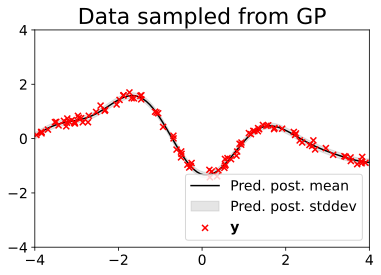

In [24]:
# Plot inducing points and observed data
plt.figure(figsize=(6, 4))

# Plot mean of generative model
plt.plot(x_plot,
         y_plot_mean,
         color='black', 
         zorder=2,
         label='Pred. post. mean')

# Plot noise of generative model
plt.fill_between(x_plot[:, 0],
                 y_plot_mean - y_plot_std,
                 y_plot_mean + y_plot_std,
                 color='gray',
                 zorder=1,
                 alpha=0.2,
                 label='Pred. post. stddev')

# Plot sampled data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='x',
            zorder=3,
            label=r'$\mathbf{y}$')

# Plot formatting
plt.title('Data sampled from GP', fontsize=22)
plt.xticks(np.arange(-4, 5, 2), fontsize=14)
plt.yticks(np.arange(-4, 5, 2), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-4., 4.])
plt.show()

In [20]:
class constant_mean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='eq_covariance'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class eq_covariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (1, -1))

        assert log_scales.shape[-1] == dim,                \
            f'Expected the size of scales at axis 2 '    + \
            f'to be dim, found shapes {scales.shape} '   + \
            f'and {dim}.'

        assert log_coeff.shape == (),                     \
            f'Expected coeff to be a single scalar, '   + \
            f'found coeff.shape == {coeff.shape}.'
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
    
    @property
    def scales(self):
        return 10 ** self.log_scales
    
    
    @property
    def coeff(self):
        return 10 ** self.log_coeff
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag_only=False,
                 epsilon=None):
        
        # Reshape input tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Check dimensions are correct
        assert (tf.rank(x1) == tf.rank(x2) == 2) and       \
               (x1.shape[1] == x2.shape[1] == self.dim),   \
            f'Expected x1 and x2 to have 2 dimensions '  + \
            f'and to both match self.dim at second '     + \
            f'dimension, instead found shapes '          + \
            f'{x1.shape} and {x2.shape}.'

        scales = self.scales
        
        # If not calculating diagonal only, expand to broadcast
        if not diag_only:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, :, :] ** 2

        # Compute differences
        diffs = x1 - x2

        # Compute quadratic form
        quad = - 0.5 * diffs ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)

        # Exponentiate and multiply by covariance coeff
        exp_quad = tf.exp(quad)
        eq_cov = self.coeff ** 2 * exp_quad
        
        # Add epsilon for invertibility
        if epsilon is not None:
            
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], dtype=self.dtype)

        return eq_cov

In [21]:
class VFEGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 dtype,
                 name='vfe-gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train,
                                            dtype=dtype)
        
        self.y_train = tf.convert_to_tensor(y_train,
                                            dtype=dtype)
        
        self.x_ind = tf.convert_to_tensor(x_ind_init,
                                          dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
    def post_pred(self, x_pred):
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-4)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_pred_ind = self.cov(x_pred, self.x_ind)
        K_ind_pred = self.cov(self.x_ind, x_pred)
        K_pred_pred_diag = self.cov(x_pred, x_pred, diag_only=True)
        
        U = K_ind_ind + tf.matmul(K_ind_train, K_train_ind) / self.noise
        U_chol = tf.linalg.cholesky(U)
        
        diff = self.y_train - self.mean(self.x_train)[:, None]
        beta = tf.linalg.cholesky_solve(U_chol, tf.matmul(K_ind_train, diff)) / self.noise
        
        mean = tf.matmul(K_pred_ind, beta)[:, 0] + self.mean(x_pred)
        
        L = tf.linalg.cholesky(K_ind_ind)
        U = tf.linalg.triangular_solve(L, K_ind_pred, lower=True)
        var = K_pred_pred_diag - tf.linalg.diag_part(tf.matmul(U, U, transpose_a=True)) + self.noise ** 2
        
        return mean, var
        
        
    def free_energy(self):
        
        # Number of training points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-6)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_train_train = self.cov(self.x_train, self.x_train)
        
        # Compute shared matrix and its cholesky:
        # LLT = K_ind_ind
        # U = I + L-1 K_train_ind K_ind_train L / noise ** 2
        L = tf.linalg.cholesky(K_ind_ind)
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        # Compute log-normalising constant of the matrix
        log_pi = - N / 2 * tf.math.log(tf.constant(2 * np.pi, dtype=self.dtype))
        log_det_B = - 0.5 * tf.linalg.slogdet(B)[1]
        log_det_noise = - N / 2 * tf.math.log(self.noise ** 2)
        
        # Log of determinant of normalising term
        log_det = log_pi + log_det_B + log_det_noise       
        
        # Compute quadratic form
        diff = self.y_train - self.mean(self.x_train)[:, None]
        c = tf.linalg.triangular_solve(B_chol, tf.matmul(A, diff), lower=True) / self.noise
        quad = - 0.5 * tf.reduce_sum((diff / self.noise) ** 2)
        quad = quad + 0.5 * tf.reduce_sum(c ** 2)
        
        # Compute trace term
        trace = - 0.5 * tf.linalg.trace(K_train_train) / self.noise ** 2
        trace = trace + 0.5 * tf.linalg.trace(tf.matmul(A, A, transpose_b=True))
        
        free_energy = (log_det + quad + trace) / N
        
        return free_energy
    
    
    @property
    def noise(self):
        return 10 ** self.log_noise

In [22]:
def plot(model,
         x_pred,
         x_train,
         y_train,
         x_ind_init,
         step):

    mean, var = model.post_pred(x_pred)

    x_pred = x_pred[:, 0].numpy()
    mean = mean.numpy()
    var = var.numpy()
    
    x_ind = model.x_ind[:, 0].numpy()

    plt.plot(x_pred, mean, color='black', label='$y^*$ mean')
    
    plt.fill_between(x_pred,
                     mean - var ** 0.5,
                     mean + var ** 0.5,
                     color='gray',
                     alpha=0.3,
                     label='$y^*$ stddev')

    plt.scatter(x_train, y_train, color='red', marker='x')
    
    plt.scatter(x_ind,
                -5. * tf.ones_like(x_ind),
                color='blue',
                marker='+',
                label=r'Current $\bar{\mathbf{X}}$')
    
    plt.scatter(x_ind_init,
                -5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$')
    
    plt.title(f'VFE after {step} optimisation steps', fontsize=18)
    plt.xticks(np.arange(-10, 11, 4), fontsize=14)
    plt.yticks(np.arange(-6, 7, 3), fontsize=14)
    plt.xlim([-8., 8.])
    plt.ylim([-8., 4.])
    plt.legend(loc='lower right', fontsize=10)
    plt.show()
    
    
def print_numbers(model, step):
    
    free_energy = model.free_energy()
    print(f'Step: {step:5>} '
          f'Free energy: {free_energy.numpy():8.3f} '
          f'Log coeff: {model.cov.log_coeff.numpy():5.2f} '
          f'Log scales: {[round(num[0], 3) for num in model.cov.log_scales.numpy()]} '
          f'Log noise: {model.log_noise.numpy():5.2f}')

Step: 0 Free energy:  -30.972 Log coeff:  0.00 Log scales: [0.0] Log noise: -1.00


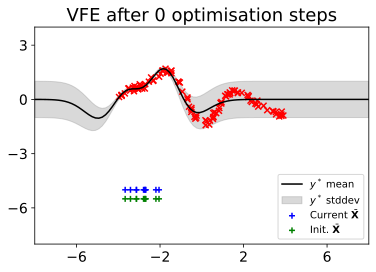

Step: 1000 Free energy:    0.546 Log coeff:  0.07 Log scales: [0.047] Log noise: -0.99


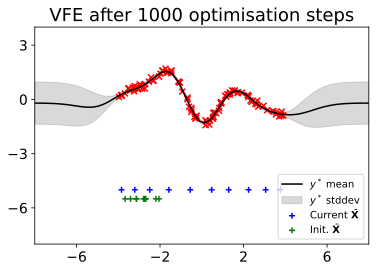

In [23]:
# Set random seed and tensor dtype
tf.random.set_seed(1)
dtype = tf.float64

# Number GP constants
M = 10
inducing_range = (-4., -2.)
log_noise = -1.
log_coeff = 0.
log_scales = [0.]

# Define mean and covariance
mean = constant_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=1,
                    dtype=dtype)

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(low=inducing_range[0], high=inducing_range[1])
x_ind_init = x_ind_dist.sample(sample_shape=(M, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Define sparse GP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               log_noise=log_noise,
               x_train=x_train,
               y_train=y_train,
               x_ind_init=x_ind_init,
               dtype=dtype)

optimizer = tf.keras.optimizers.Adam(1e-1)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=tf.float64)

for step in range(1001):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        
        if step % 1000 == 0:
            
            print_numbers(vfe_gp,
                          step)

            plot(vfe_gp,
                 x_pred,
                 x_train,
                 y_train,
                 x_ind_init,
                 step)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))

## Notes and questions:

- Why is the ELBO cheap to evaluate?
- VFE and FITC have the same predictive posterior. Would that be obviously expected from a KL argument?
- How tight is the bound in general? Compute the KL.

Tightness of bound and expressiveness of approximate posterior are different things in general. An approximate posterior can be used to get an exact log-likelihood. But if we use the KL ELBO, then the expressiveness of $q$ and the tightness of the bound are closely related.




Furthermore, whereas other methods optimise approximations to 

This distinction offers several crucial benefits to VFE:

1. VFE decouples model assumptions and approximations. It keeps the original model sacrosanct and attempts to approximate it as faithfully as possible.
2. By leaving the original GP untouched and attempting to approximate its posterior, it is impossible for VFE to overfit more than the original GP. By contrast, other methods can overfit more than the original GP.
3. VFE explicitly represents posterior uncertainty, keeping it separate from noise uncertainty whereas methods do not. DTC ignores posterior uncertainty of the conditional prior, and FITC mixes up posterior and 

